<a href="https://colab.research.google.com/github/ravmarcin/GoogleColab/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install tensorflow==2.3.0
! pip install keras==2.4.3

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf
import keras
import os
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Ignore the log about CPU usage
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Ignore the log about repeated tf process
tf.get_logger().setLevel('ERROR')


In [ ]:
class TimeSeriesModel(object):

    def __init__(self,
                 col_oil="Oil Rate SC",
                 col_gas="Gas Mass Rate(CO2) SC",
                 col_water="Water Rate SC",
                 col_t="Time (day)",
                 dir_="/content/drive/MyDrive/Colab Notebooks/Existing_wells/",
                 dir_n_well="/content/drive/MyDrive/Colab Notebooks/New_well/",
                 col_por="Porosity ",
                 col_per="Permeability",
                 col_fm="Fm Thickness",
                 col_bhp="BHP",
                 i_coor_col="i",
                 j_coor_col="j",
                 model_=LinearRegression(),
                 n_old_obs=20,
                 n_well=8,
                 train_=0.4,
                 valid_=0.2,
                 test_=0.4,
                 factor_=20,
                 mod_update=200,
                 w_model_init=0.5,
                 w_model_update=0.5,
                 lin_=True,
                 lstm_=False,
                 dense_=False,
                 sec_order=False,
                 pred_round=True,
                 epochs=10,
                 mod_temp_dir="./model_temp/"
                 ):
        self.col_gas = col_gas
        self.col_water = col_water
        self.dir_ = dir_
        self.dir_n_well = dir_n_well
        self.col_time = col_t
        self.i_coor_col = i_coor_col
        self.j_coor_col = j_coor_col
        self.col_coor = [i_coor_col, j_coor_col]
        self.var_col = [col_oil, col_gas, col_water]
        self.const_col = [col_por, col_per, col_fm, col_bhp]
        self.col_ls = [col_oil, col_gas, col_water, col_por, col_per, col_fm, col_bhp]
        self.model_ = model_
        if n_old_obs > 3:
            self.n_old_obs = n_old_obs
        else:
            self.n_old_obs = 3
        self.n_well = n_well
        self.train_ = train_
        self.valid_ = valid_
        self.test_ = test_
        self.factor_ = factor_
        self.mod_update = mod_update
        self.w_model_init = w_model_init
        self.w_model_update = w_model_update
        self.sec_order = sec_order
        self.pred_round = pred_round
        self.epochs = epochs
        self.mod_temp_dir = mod_temp_dir

        self.lin_ = lin_
        self.lstm_ = lstm_
        self.dense_ = dense_

        if self.lin_:
            self.dense_ = False
            self.lstm_ = False
        elif self.dense_:
            self.lstm_ = False
        else:
            self.lstm_ = True

    """ Import data function """

    def import_data(self, dir_, roll=True, roll_par=60, ext_1="PRO-", ext_2=".csv", pro_="01"):
        """
        Input:
            dir_: a directory for data
            rolling: a boolean value, if True then Gas, Oil, and Water values are rolled
        Output:
            pro_df_r: a true (real) pandas dataframe (df)
            pro_df: a convert pandas dataframe (df)
        """

        # read data from the dir_:
        pro_df_r = pd.read_csv(dir_ + ext_1 + pro_ + ext_2, sep=',', encoding="ISO-8859-1")
        pro_df = pro_df_r.copy()

        # roll the Gas, Oil and Water values:
        if roll:
            for col_ in self.var_col:
                pro_df[col_] = \
                    pro_df[col_].rolling(roll_par, min_periods=1).mean()

        return pro_df_r, pro_df

    def normalization(self, pro_df_ls, mean_=None, sigma_=None, init_=True):

        for j in range(len(self.const_col)):
            if init_:
                const_ = []
                for i in range(self.n_well):
                    const_.append(pro_df_ls[i][self.const_col[j]].to_numpy()[0])
                const_ = np.array(const_)
                sigma_ = np.std(const_)
                mean_ = np.mean(const_)
                for i in range(self.n_well):
                    norm_col = (pro_df_ls[i][self.const_col[j]] - mean_) / sigma_
                    pro_df_ls[i][self.const_col[j]] = norm_col
            else:
                norm_col = (pro_df_ls[self.const_col[j]] - mean_) / sigma_
                pro_df_ls[self.const_col[j]] = norm_col

        return pro_df_ls, [mean_, sigma_]

    """ Get list of all dataframes """

    def get_df_list(self, dir_, norm_, init_=True, ext_1="PRO-", roll=True, pro_="03"):
        """
        Input:
            pro_n: a number of wells
        Output:
            pro_df_r_ls: a list of a true (real) pandas dataframe (n_df, df)
            pro_df_ls: a list of a convert pandas dataframe (n_df, df)
        """

        # create empty lists:
        pro_df_r_ls, pro_df_ls = [], []

        # loop trough the number of wells:
        if init_:
            for i in range(self.n_well):
                pro_ = "0" + str(i + 1)

                # import dataframes for a given well number:
                pro_df_r, pro_df = self.import_data(dir_=dir_, roll=True, roll_par=60, ext_1=ext_1, ext_2=".csv",
                                                    pro_=pro_)
                pro_df_r_ls.append(pro_df_r)
                pro_df_ls.append(pro_df)

            pro_df_ls, norm_ = self.normalization(pro_df_ls=pro_df_ls, init_=init_)
        else:
            pro_df_r_ls, pro_df_ls = self.import_data(dir_=dir_, roll=True, roll_par=60, ext_1=ext_1, ext_2=".csv",
                                                      pro_=pro_)
            pro_df_ls, _ = self.normalization(pro_df_ls=pro_df_ls, init_=init_, mean_=norm_[0], sigma_=norm_[1])

        return pro_df_r_ls, pro_df_ls, norm_

    """ Spliting function """

    def get_train_test(self, df_list):
        """
        Input:
            df_list: a list of dataframes (n_df, df)
            train_: a number corresponding to the train part
        Output:
            df_list_train: a training list of dataframes (n_df, df_rows * train_)
            df_list_test: a testing list of dataframes (n_df, df_rows * (1 - train_))
        """

        # a number rows in the array:
        n_rows = len(df_list[0])

        # a number rows for train:
        train_n = int(n_rows * self.train_)
        val_n = train_n + int(n_rows * self.valid_)
        test_n = val_n + int(n_rows * self.test_)

        df_ls_train, df_ls_val, df_ls_test = [], [], []
        for df_ in df_list:
            # split to train and test:
            df_train = df_.iloc[:train_n]
            df_val = df_.iloc[train_n:val_n]
            df_test = df_.iloc[val_n:test_n]

            df_ls_train.append(df_train)
            df_ls_val.append(df_val)
            df_ls_test.append(df_test)

        return df_ls_train, df_ls_val, df_ls_test

    """ Well positions matrix function """

    def get_well_position(self, df_list, init_=True):
        """
        Input:
            df_list: a list of dataframes (n_df, df)
        Output:
            well_position: a numpy array of well positions (n_df, n_coor)
        """

        # an empty list:
        well_position = []

        # loop trough the dataframes and get i-th and j-th coordinates:
        if init_:
            for df_ in df_list:
                well_position.append([df_['i'].values[0], df_['j'].values[0]])
        else:
            well_position = [df_list['i'].values[0], df_list['j'].values[0]]
        # convert to numpy array
        return np.array(well_position)

    """ Weighting distance matrix function """

    def get_weight(self, well_position, empty=False):
        """
        Input:
            well_position: a numpy array of a well positions (n_df, n_coor)
            eps_: an addition to remove 0 values from denominator (always=1)
            factor_: a weighting factor
        Output:
            weight_matrix: a numpy array of weighting distance (n_df, n_df)
        """

        # a number of wells:
        pro_n = len(well_position)

        # an empty list:
        distance_ = []

        # loop trough the dataframes:
        for i in range(pro_n):

            # an empty list for i-th dataframe:
            distance_j = []

            # loop trough the dataframes:
            for j in range(pro_n):
                # calculate the distance between i-th and j-th well
                distance = np.linalg.norm(well_position[i, :] - well_position[j, :])
                distance_j.append(distance)
            distance_.append(distance_j)

        # stack the i-th distances vectors
        distance_ = np.vstack(distance_)

        # distance for the current wells:
        distance_[distance_ == 0] = 1

        # compute the distance weighting matrix
        weight_matrix = 1 / distance_ ** self.factor_

        if empty:
            # weights for the other wells:
            weight_matrix[weight_matrix != 1] = 0

        return weight_matrix

    """ Values in numpy array function """

    def get_val_in_arr(self, pro_df_ls, col_):
        """
        Input:
            df_list: a list of dataframes (n_df, df)
            col_: a name of the column (string)
        Output:
            df_values: a numpy array of values for given column (n_df, df_rows)
        """

        # an empty list:
        df_values = []

        # loop trough the dataframes:
        for df_ in pro_df_ls:
            # get the values from given column name:
            df_values.append(df_[col_].values)

        # return a numpy array of a list
        return np.array(df_values)

    """ Weighted value arrays function """

    def get_weigthed_arr(self, arr_, weight_matrix):
        """
        Input:
            arr_: a numpy array of the values for given variable (n_df, df_rows)
            weight_matrix: a numpy array of weighting distance (n_df, n_df)
        Output:
            arr_w: a numpy array of the weighted values for given variable (n_df, df_rows, n_df)
        """

        # a number of wells:
        pro_n = np.shape(arr_)[0]

        # an empty list:
        arr_w = []

        # loop trough the dataframes:
        for i in range(pro_n):
            # multiply the values by the weight distance matrix
            arr_w.append(np.array(arr_).T * np.atleast_2d(weight_matrix[i, :]))

        # return a numpy array of a list
        return np.array(arr_w)

    """ Compute gradient function """

    def get_grad(self, var_ls):
        """
        Input:
            var_ls: the list of variables in numpy array
        Output:
            var_grad_ls: the list of gradients in numpy array
        """

        # an empty list:
        var_grad_ls = []

        # loop trough the list
        for var_ in var_ls:
            var_grad = var_[:, 1:-1] - var_[:, :-2]
            # add first two gradient for correctness
            var_grad = np.append(var_grad[:, :2], var_grad, axis=1)
            var_grad_ls.append(var_grad)

        return var_grad_ls

    """ Pipeline initialization function """

    def pipeline_init(self, df_list, weight_matrix, init_=True):
        """
        Input:
            df_list:
            col_ls:
            train_:
        Output:
            var_ls_train:
            var_ls_test:
            const_ls_train:
            const_ls_test:
            weight_matrix:
        """

        # import function:
        pro_df_ls_train, pro_df_ls_val, pro_df_ls_test = self.get_train_test(df_list=df_list)
        print("Data are imported.")

        # well positions matrix function:
        well_position = self.get_well_position(df_list=pro_df_ls_train)

        # weighting distance matrix function:
        if init_:
            weight_matrix = self.get_weight(well_position)

        # values in numpy array function:
        rate_train_ls, rate_val_ls, rate_test_ls = [], [], []
        for col_ in self.col_ls:
            rate_train = self.get_val_in_arr(pro_df_ls=pro_df_ls_train, col_=col_)
            rate_val = self.get_val_in_arr(pro_df_ls=pro_df_ls_val, col_=col_)
            rate_test = self.get_val_in_arr(pro_df_ls=pro_df_ls_test, col_=col_)
            rate_train_ls.append(rate_train)
            rate_val_ls.append(rate_val)
            rate_test_ls.append(rate_test)
        time_train = self.get_val_in_arr(pro_df_ls=pro_df_ls_train, col_=self.col_time)
        time_val = self.get_val_in_arr(pro_df_ls=pro_df_ls_val, col_=self.col_time)
        time_test = self.get_val_in_arr(pro_df_ls=pro_df_ls_test, col_=self.col_time)

        # get coordinate values:
        coor_train_ls, coor_val_ls, coor_test_ls = [], [], []
        for col_ in self.col_coor:
            coor_train = self.get_val_in_arr(pro_df_ls=pro_df_ls_train, col_=col_)
            coor_val = self.get_val_in_arr(pro_df_ls=pro_df_ls_val, col_=col_)
            coor_test = self.get_val_in_arr(pro_df_ls=pro_df_ls_test, col_=col_)
            coor_train_ls.append(coor_train)
            coor_val_ls.append(coor_val)
            coor_test_ls.append(coor_test)

        # get gradient values:
        grad_train_ls = self.get_grad(var_ls=rate_train_ls[0:3])
        grad_val_ls = self.get_grad(var_ls=rate_val_ls[0:3])
        grad_test_ls = self.get_grad(var_ls=rate_test_ls[0:3])

        # weighted value arrays function:
        rate_w_train_ls, rate_w_val_ls, rate_w_test_ls = [], [], []
        grad_w_train_ls, grad_w_val_ls, grad_w_test_ls = [], [], []
        for i in range(len(rate_train_ls)):
            rate_w_train = self.get_weigthed_arr(arr_=rate_train_ls[i], weight_matrix=weight_matrix)
            rate_w_val = self.get_weigthed_arr(arr_=rate_val_ls[i], weight_matrix=weight_matrix)
            rate_w_test = self.get_weigthed_arr(arr_=rate_test_ls[i], weight_matrix=weight_matrix)
            rate_w_train_ls.append(rate_w_train)
            rate_w_val_ls.append(rate_w_val)
            rate_w_test_ls.append(rate_w_test)
        for i in range(len(grad_train_ls)):
            grad_w_train = self.get_weigthed_arr(arr_=grad_train_ls[i], weight_matrix=weight_matrix)
            grad_w_val = self.get_weigthed_arr(arr_=grad_val_ls[i], weight_matrix=weight_matrix)
            grad_w_test = self.get_weigthed_arr(arr_=grad_test_ls[i], weight_matrix=weight_matrix)
            grad_w_train_ls.append(grad_w_train)
            grad_w_val_ls.append(grad_w_val)
            grad_w_test_ls.append(grad_w_test)

        # split values to variables and constants:
        var_ls_train, var_ls_val, var_ls_test = [], [], []
        const_ls_train, const_ls_val, const_ls_test = [], [], []
        for i in range(len(self.col_ls)):
            if self.col_ls[i] in self.var_col:
                var_ls_train.append(rate_w_train_ls[i])
                var_ls_val.append(rate_w_val_ls[i])
                var_ls_test.append(rate_w_test_ls[i])
            else:
                const_ls_train.append(rate_w_train_ls[i])
                const_ls_val.append(rate_w_val_ls[i])
                const_ls_test.append(rate_w_test_ls[i])
        print("Date are separated to variables, gradients, constants, coordinates, and time.")

        if init_:
            return var_ls_train, var_ls_test, const_ls_train, const_ls_test, weight_matrix, \
                   time_train, time_test, grad_w_train_ls, grad_w_test_ls, coor_train_ls, coor_test_ls, \
                   var_ls_val, const_ls_val, time_val, grad_w_val_ls, coor_val_ls
        else:
            return var_ls_test, const_ls_test, time_test, grad_w_test_ls, coor_test_ls

    """ Splitting to wells number function """

    def split_data(self, var_w_ls_, const_w_ls_, time_, grad_w_ls_, coor_ls_, title_="training"):

        var_split = []
        grad_split = []
        target_split = []
        time_split = []
        for i in range(self.n_well):
            var_i_ = []
            grad_i_ = []
            target_i_ = []
            for j in range(len(self.var_col)):
                var_i_j = var_w_ls_[j][i, :, :]
                grad_i_j = grad_w_ls_[j][i, :, :]
                target_i_j = var_w_ls_[j][i, :, i]
                var_i_.append(var_i_j)
                grad_i_.append(grad_i_j)
                target_i_.append(target_i_j)
            var_split.append(var_i_)
            grad_split.append(grad_i_)
            target_split.append(target_i_)
            time_split.append(time_[i, :])

        const_split = []
        for i in range(self.n_well):
            const_i_ = []
            for j in range(len(self.const_col)):
                const_i_j = const_w_ls_[j][i, :, :]
                const_i_.append(const_i_j)
            const_split.append(const_i_)

        coor_split = []
        for i in range(self.n_well):
            coor_i_ = []
            for j in range(len(self.col_coor)):
                coor_i_j = coor_ls_[j][i, :]
                coor_i_.append(coor_i_j)
            coor_split.append(coor_i_)
        print("Date are splitted to each well for " + str(title_) + " dataset.")
        return var_split, const_split, time_split, grad_split, coor_split, target_split

    def connect_data(self, var_o, const_o, time_o, grad_o, coor_o, target_o,
                     var_n, const_n, time_n, grad_n, coor_n, target_n):

        var_con, const_con, time_con, grad_con, coor_con, target_con = [], [], [], [], [], []

        for well_ in range(self.n_well):
            var_con_i, const_con_i, grad_con_i, coor_con_i, target_con_i \
                = [], [], [], [], []

            time_con_i = np.append(time_o[well_], time_n[well_], axis=0)
            for i in range(len(self.var_col)):
                var_con_i_well = np.append(var_o[well_][i], var_n[well_][i], axis=0)
                var_con_i.append(var_con_i_well)
                grad_con_i_well = np.append(grad_o[well_][i], grad_n[well_][i], axis=0)
                grad_con_i.append(grad_con_i_well)
                target_con_i_well = np.append(target_o[well_][i], target_n[well_][i], axis=0)
                target_con_i.append(target_con_i_well)
            for i in range(len(self.const_col)):
                const_con_i_well = np.append(const_o[well_][i], const_n[well_][i], axis=0)
                const_con_i.append(const_con_i_well)
            for i in range(len(self.col_coor)):
                coor_con_i_well = np.append(coor_o[well_][i], coor_n[well_][i], axis=0)
                coor_con_i.append(coor_con_i_well)
            var_con.append(var_con_i)
            const_con.append(const_con_i)
            time_con.append(time_con_i)
            grad_con.append(grad_con_i)
            coor_con.append(coor_con_i)
            target_con.append(target_con_i)

        print("Provided data are connected")
        return var_con, const_con, time_con, grad_con, coor_con, target_con

    def get_data_target(self, var_, const_, time_, grad_, coor_, target_, bias_=None):
        target_arr = np.array(target_)[:, self.n_old_obs:]
        for old_ in range(self.n_old_obs):
            if old_ == 0:
                obs_arr_ = var_[0][old_:-(self.n_old_obs - old_), :]
                for i in range(1, len(self.var_col)):
                    obs_arr_ = np.append(obs_arr_, var_[i][old_:-(self.n_old_obs - old_), :], axis=1)
            else:
                for i in range(len(self.var_col)):
                    obs_arr_ = np.append(obs_arr_, var_[i][old_:-(self.n_old_obs - old_), :], axis=1)
            if self.sec_order:
                for i in range(len(self.var_col)):
                    obs_arr_ = np.append(obs_arr_, np.power(var_[i][old_:-(self.n_old_obs - old_), :], 2), axis=1)
            for i in range(len(self.var_col)):
                obs_arr_ = np.append(obs_arr_, grad_[i][old_:-(self.n_old_obs - old_), :], axis=1)
            for i in range(len(self.const_col)):
                obs_arr_ = np.append(obs_arr_, const_[i][old_:-(self.n_old_obs - old_), :], axis=1)
            for i in range(len(self.col_coor)):
                obs_arr_ = np.append(obs_arr_, np.atleast_2d(coor_[i][old_:-(self.n_old_obs - old_)]).T, axis=1)
        obs_arr_ = np.append(obs_arr_, np.atleast_2d(time_[self.n_old_obs:]).T, axis=1)
        if bias_ is None:
            bias_ = np.ones((np.shape(obs_arr_)[0], 1))
        obs_arr_ = np.append(obs_arr_, bias_, axis=1)

        return obs_arr_, target_arr

    def get_starters(self, var_, const_, time_, grad_, coor_, target_):
        target_arr = [ta_[1:self.n_old_obs + 3] for ta_ in target_]
        var_arr_ = [np.atleast_2d(v_[:self.n_old_obs + 3, :]) for v_ in var_]
        grad_arr_ = [np.atleast_2d(g_[:self.n_old_obs + 3, :]) for g_ in grad_]
        const_arr_ = [np.atleast_2d(c_[:self.n_old_obs + 3, :]) for c_ in const_]
        coor_arr_ = [co_[:self.n_old_obs + 3] for co_ in coor_]
        time_arr_ = time_[:self.n_old_obs + 3]
        return var_arr_, const_arr_, time_arr_, grad_arr_, coor_arr_, target_arr

    def get_endings(self, var_, const_, time_, grad_, coor_, target_, minus_start=0):
        target_arr = [ta_[-(self.n_old_obs + 3 + minus_start):] for ta_ in target_]
        var_arr_ = [np.atleast_2d(v_[-(self.n_old_obs + 3 + minus_start):, :]) for v_ in var_]
        grad_arr_ = [np.atleast_2d(g_[-(self.n_old_obs + 3 + minus_start):, :]) for g_ in grad_]
        const_arr_ = [np.atleast_2d(c_[-(self.n_old_obs + 3 + minus_start):, :]) for c_ in const_]
        coor_arr_ = [co_[-(self.n_old_obs + 3 + minus_start):] for co_ in coor_]
        time_arr_ = time_[-(self.n_old_obs + 3 + minus_start):]
        return var_arr_, const_arr_, time_arr_, grad_arr_, coor_arr_, target_arr

    """ Pipeline modeling for splited data function """

    def pipeline_model_split(self, var_split, const_split, time_split, grad_split,
                             coor_split, target_split, plot_=False):

        # observation matrix creation function:
        a_ls = []
        l_ls = []
        model_ls = []
        l_pred_ls = []
        rmse_ls_all, std_ls_all = [], []
        score_ls_all, score_ls_all_ls = [], []
        for i in range(self.n_well):
            a_i_, l_i = self.get_data_target(var_=var_split[i], const_=const_split[i], time_=time_split[i],
                                             grad_=grad_split[i], coor_=coor_split[i], target_=target_split[i])
            a_ls.append(a_i_)
            l_ls.append(l_i)
            score_ls, rmse_ls, std_ls = [], [], []

            if self.lin_:
                self.lin_model()
                lin_model = self.model_
                model_ls_var = MultiOutputRegressor(estimator=lin_model)
                model_ls_var.fit(a_i_, l_i.T)
                l_i_pred = model_ls_var.predict(a_i_)
                for var_ in range(len(self.var_col)):
                    score_, rmse_, std_ = self.model_score(y_=l_i[var_], y_pred_=l_i_pred.T[var_])
                    score_ls.append(score_)
                    rmse_ls.append(rmse_)
                    std_ls.append(std_)

            if self.lstm_ or self.dense_:
                if self.dense_:
                    self.dense_model()
                elif self.lstm_:
                    self.lstm_model()
                a_conv, a_rs_conv, l_ls_conv = self.make_dataset_ts(data_train=a_i_, data_target=l_i)
                print("Dataset for well no. " + str(i + 1) + " is prepared for keras.")
                model_ls_var = []
                l_i_pred = []
                for var_ in range(len(self.var_col)):
                    model_var = self.model_
                    his_ = self.compile_and_fit(model=model_var, data=(a_rs_conv, l_ls_conv[var_]))

                    # Temporary save the model
                    mod_temp_dir_w = self.mod_temp_dir + "Well_no_" + str(i + 1)
                    if not os.path.exists(mod_temp_dir_w):
                        os.mkdir(mod_temp_dir_w)
                    mod_temp_dir_w = mod_temp_dir_w + "/Model_" + str(self.var_col[var_])
                    model_var.save(mod_temp_dir_w)
                    l_i_pred_var = model_var.predict(a_rs_conv)
                    l_i_pred_var = l_i_pred_var[:, 0, 0]
                    score_, rmse_, std_ = self.model_score(y_=l_ls_conv[var_], y_pred_=l_i_pred_var)
                    score_ls.append(score_)
                    rmse_ls.append(rmse_)
                    std_ls.append(std_)
                    l_i_pred.append(l_i_pred_var)
                    model_ls_var.append(model_var)

            score_ls_avg = np.mean(np.array(score_ls))
            model_ls.append(model_ls_var)
            score_ls_all.append(score_ls_avg)
            score_ls_all_ls.append(score_ls)
            l_pred_ls.append(l_i_pred)
            rmse_ls_all.append(rmse_ls)
            std_ls_all.append(std_ls)
            if plot_:
                for var_ in range(len(self.var_col)):
                    if self.dense_ or self.lstm_:
                        y_pred_ = l_i_pred[var_]
                    elif self.lin_:
                        y_pred_ = l_i_pred.T[var_]
                    x_ = time_split[i][self.n_old_obs:]
                    y_ = l_i[var_]
                    title_ = "Prediction for well no. " + str(i + 1) + " " + str(self.var_col[var_])
                    self.get_plot(x_=x_, y_=y_, y_pred=y_pred_, y_label=title_)
                    print("Model for well number " + str(i + 1) + " and " + str(self.var_col[var_]) +
                          " is fitted with RMSE: " + str("{:.4f}".format(rmse_ls[var_])) + ".")
            print("Model for well number " + str(i + 1) + " is fitted with average error: " + str(
                "{:.4f}".format(score_ls_avg)) + "%.")
        print("Model is fitted with error: " + str("{:.4f}".format(np.mean(np.array(score_ls_all)))) + "%.")
        time_ax = time_split[0][self.n_old_obs:]
        return a_ls, l_ls, l_pred_ls, model_ls, score_ls_all_ls, rmse_ls_all, std_ls_all, time_ax

    def get_prediction(self, model_, var_split, const_split, time_split, grad_split,
                       coor_split, target_split, plot_=False, new_well=False):

        avg_score, l_ls, l_pred_ls = [], [], []
        rmse_ls_all, std_ls_all = [], []
        for well_ in range(self.n_well):
            a_i_, l_i = self.get_data_target(var_=var_split[well_], const_=const_split[well_], time_=time_split[well_],
                                             grad_=grad_split[well_], coor_=coor_split[well_],
                                             target_=target_split[well_])
            l_ls.append(l_i)
            avg_score_well, rmse_well, std_well = [], [], []
            if self.lin_:
                l_pred = model_[well_].predict(a_i_)
                l_i_pred = []
                for var_ in range(len(self.var_col)):
                    x_ = time_split[well_][self.n_old_obs:]
                    y_ = l_i[var_]
                    l_i_pred_var = l_pred.T[var_]
                    avg_score_well_var, rmse_well_var, std_well_var = self.model_score(y_=y_, y_pred_=l_i_pred_var)
                    avg_score_well.append(avg_score_well_var)
                    rmse_well.append(rmse_well_var)
                    std_well.append(std_well_var)
                    l_i_pred.append(l_i_pred_var)
                    if plot_:
                        title_ = "Prediction for well no. " + str(well_ + 1) + " " + str(self.var_col[var_])
                        self.get_plot(x_=x_, y_=y_, y_pred=l_i_pred_var, y_label=title_)
                        if not new_well:
                            print("Model for well number " + str(well_ + 1) + " and " + str(self.var_col[var_]) +
                                  " is fitted with RMSE: " + str("{:.4f}".format(rmse_well_var)) + ".")

            if self.lstm_ or self.dense_:
                a_conv, a_rs_conv, l_ls_conv = self.make_dataset_ts(data_train=a_i_, data_target=l_i)
                print("Dataset for well no. " + str(well_ + 1) + " is prepared for keras.")
                l_i_pred = []
                for var_ in range(len(self.var_col)):
                    x_ = time_split[well_][self.n_old_obs:]
                    y_ = l_ls_conv[var_]
                    # Load the temporary model
                    mod_temp_dir_w = self.mod_temp_dir + "Well_no_" + str(well_ + 1)
                    mod_temp_dir_w = mod_temp_dir_w + "/Model_" + str(self.var_col[var_])
                    model_ = keras.models.load_model(mod_temp_dir_w)

                    l_i_pred_var = model_.predict(a_rs_conv)
                    del model_
                    l_i_pred_var = l_i_pred_var[:, 0, 0]
                    avg_score_well_var, rmse_well_var, std_well_var = self.model_score(y_=y_, y_pred_=l_i_pred_var)
                    avg_score_well.append(avg_score_well_var)
                    rmse_well.append(rmse_well_var)
                    std_well.append(std_well_var)
                    l_i_pred.append(l_i_pred_var)
                    if plot_:
                        title_ = "Prediction for well no. " + str(well_ + 1) + " " + str(self.var_col[var_])
                        self.get_plot(x_=x_, y_=y_, y_pred=l_i_pred_var, y_label=title_)
                        if not new_well:
                            print("Model for well number " + str(well_ + 1) + " and " + str(self.var_col[var_]) +
                                  " is fitted with RMSE: " + str("{:.4f}".format(rmse_well_var)) + ".")
            l_pred_ls.append(l_i_pred)
            if not new_well:
                print("The error for model for well number " + str(well_ + 1)
                      + ": " + str("{:.4f}".format(np.mean(np.array(avg_score_well)))) + "%")

            avg_score.append(avg_score_well)
            rmse_ls_all.append(rmse_well)
            std_ls_all.append(std_well)
        avg_score_tot = [np.sum(np.array(arr_)) for arr_ in avg_score]
        avg_score_t = np.sum(avg_score_tot) / (self.n_well + len(self.var_col))
        if not new_well:
            print("Average error for the prediction for all variables and wells: "
                  + str("{:.4}".format(avg_score_t)) + "%")
        time_ax = time_split[0][self.n_old_obs:]
        return l_ls, l_pred_ls, avg_score, rmse_ls_all, std_ls_all, time_ax

    def get_linear_valid_model(self, weight_matrix, var_train, const_train, time_train,
                               grad_train, coor_train, target_train, var_val, const_val,
                               time_val, grad_val, coor_val, target_val):
        n_old_obs_ls = [15, 20, 25, 30]
        mod_update_ls = [50, 100, 200]
        w_model_init_ls = [0.00, 0.5, 1.00]

        print("------------------------------")
        print("Model validation for the number of old observations is started")

        avg_score_old_obs_ls = []
        for old_obs in n_old_obs_ls:
            self.n_old_obs = old_obs
            print("------------------------------")
            print("Model for the number of the old observation: " + str(old_obs))
            a_ls, l_ls, l_pred_ls, model_ls, _, _, _, _ = self.pipeline_model_split(var_split=var_train,
                                                                                    const_split=const_train,
                                                                                    time_split=time_train,
                                                                                    grad_split=grad_train,
                                                                                    coor_split=coor_train,
                                                                                    target_split=target_train)
            n_iter = np.shape(time_val)[1] - (self.n_old_obs + 3)
            avg_score_old_obs, _, _, _, _, _, _ = self.get_forecast_split(model_=model_ls,
                                                                          weight_matrix=weight_matrix,
                                                                          var_split=var_val,
                                                                          const_split=const_val,
                                                                          time_split=time_val,
                                                                          grad_split=grad_val,
                                                                          coor_split=coor_val,
                                                                          target_split=target_val,
                                                                          n_iter=n_iter,
                                                                          plot_=False)
            avg_score_old_obs_ls.append(avg_score_old_obs)

        n_old_obs_idx = np.argmin(avg_score_old_obs_ls)
        n_old_obs_best = n_old_obs_ls[n_old_obs_idx]
        self.n_old_obs = n_old_obs_best
        print("Best number of the old observations:")
        print(n_old_obs_best)

        print("------------------------------")
        print("Model validation for the number of the iterations of the model update is started")

        avg_score_mod_update_ls = []
        for mod_up in mod_update_ls:
            self.mod_update = mod_up
            print("------------------------------")
            print("Model for model update:")
            print(mod_up)
            a_ls, l_ls, l_pred_ls, model_ls, _, _, _, _ = self.pipeline_model_split(var_split=var_train,
                                                                                    const_split=const_train,
                                                                                    time_split=time_train,
                                                                                    grad_split=grad_train,
                                                                                    coor_split=coor_train,
                                                                                    target_split=target_train)
            n_iter = np.shape(time_val)[1] - (self.n_old_obs + 3)
            avg_score_mod_up, _, _, _, _, _, _ = self.get_forecast_split(model_=model_ls,
                                                                         weight_matrix=weight_matrix,
                                                                         var_split=var_val,
                                                                         const_split=const_val,
                                                                         time_split=time_val,
                                                                         grad_split=grad_val,
                                                                         coor_split=coor_val,
                                                                         target_split=target_val,
                                                                         n_iter=n_iter,
                                                                         plot_=False)
            avg_score_mod_update_ls.append(avg_score_mod_up)

        mod_update_idx = np.argmin(avg_score_mod_update_ls)
        mod_update_best = mod_update_ls[mod_update_idx]
        self.mod_update = mod_update_best
        print("Best number of the iterations for model update:")
        print(mod_update_best)

        print("------------------------------")
        print("Model validation for the weight of the initial model is started")

        avg_score_w_model_init_ls = []
        for w_mod in w_model_init_ls:
            self.w_model_init = w_mod
            print("------------------------------")
            print("Model for initial model weight:")
            print(w_mod)
            a_ls, l_ls, l_pred_ls, model_ls, _, _, _, _ = self.pipeline_model_split(var_split=var_train,
                                                                                    const_split=const_train,
                                                                                    time_split=time_train,
                                                                                    grad_split=grad_train,
                                                                                    coor_split=coor_train,
                                                                                    target_split=target_train)
            n_iter = np.shape(time_val)[1] - (self.n_old_obs + 3)
            avg_score_w_mod, _, _, _, _, _, _ = self.get_forecast_split(model_=model_ls,
                                                                        weight_matrix=weight_matrix,
                                                                        var_split=var_val,
                                                                        const_split=const_val,
                                                                        time_split=time_val,
                                                                        grad_split=grad_val,
                                                                        coor_split=coor_val,
                                                                        target_split=target_val,
                                                                        n_iter=n_iter,
                                                                        plot_=False)
            avg_score_w_model_init_ls.append(avg_score_w_mod)

        w_model_init_idx = np.argmin(avg_score_w_model_init_ls)
        w_model_init_best = w_model_init_ls[w_model_init_idx]
        self.w_model_init = w_model_init_best
        print("Best weight of the initial model:")
        print(w_model_init_best)
        return n_old_obs_best, mod_update_best, w_model_init_best

    def get_forecast_split(self, model_, weight_matrix, var_split, const_split, time_split,
                           grad_split, coor_split, target_split, n_iter=None, plot_=False, new_well=False, plot_w=None):

        n_var = len(self.var_col)
        iter_process = np.round(n_iter, -1)

        l_ls_init_two = []
        l_ls_init_three = []
        if self.lin_:
            model_update_ls = model_
        l_ls_pred_two = []
        l_ls_pred_three = []
        l_ls_pred_four = []

        var_arr_ls, const_arr_ls, time_arr_ls, grad_arr_ls, coor_arr_ls, target_arr_ls = [], [], [], [], [], []

        for well_ in range(self.n_well):
            var_arr_, const_arr_, time_arr_, grad_arr_, coor_arr_, target_arr = \
                self.get_starters(var_=var_split[well_], const_=const_split[well_], time_=time_split[well_],
                                  grad_=grad_split[well_], coor_=coor_split[well_], target_=target_split[well_])

            var_arr_ls.append(var_arr_)
            const_arr_ls.append(const_arr_)
            time_arr_ls.append(time_arr_)
            grad_arr_ls.append(grad_arr_)
            coor_arr_ls.append(coor_arr_)
            target_arr_ls.append(target_arr)

        tf_models = []
        for well_ in range(self.n_well):
            a_init, l_init = self.get_data_target(var_=var_arr_ls[well_], const_=const_arr_ls[well_],
                                                  time_=time_arr_ls[well_], grad_=grad_arr_ls[well_],
                                                  coor_=coor_arr_ls[well_], target_=target_arr_ls[well_],
                                                  bias_=None)
            target_arr_ls_update = []
            if self.lin_:
                l_pred_two = model_[well_].predict([a_init[0]]).T
                l_pred_three = model_[well_].predict([a_init[1]]).T
                l_pred_four = model_[well_].predict([a_init[2]]).T
                l_pred_two[l_pred_two < 0] = 0
                l_pred_three[l_pred_three < 0] = 0
                l_pred_four[l_pred_four < 0] = 0

            elif self.dense_ or self.lstm_:
                a_conv, a_rs_conv, l_ls_conv = self.make_dataset_ts(data_train=a_init, data_target=l_init)
                l_pred_two, l_pred_three, l_pred_four = [], [], []
                tf_models_var = []
                for var_ in range(len(self.var_col)):
                    a_one = np.array([a_rs_conv[0, :, :]])
                    a_two = np.array([a_rs_conv[1, :, :]])
                    a_three = np.array([a_rs_conv[2, :, :]])

                    # Load the temporary model
                    mod_temp_dir_w = self.mod_temp_dir + "Well_no_" + str(well_ + 1)
                    mod_temp_dir_w = mod_temp_dir_w + "/Model_" + str(self.var_col[var_])
                    model_ = keras.models.load_model(mod_temp_dir_w)
                    tf_models_var.append(model_)
                    l_pred_two_var = model_.predict(a_one)[:, 0, 0]
                    l_pred_three_var = model_.predict(a_two)[:, 0, 0]
                    l_pred_four_var = model_.predict(a_three)[:, 0, 0]
                    del model_
                    l_pred_two_var[l_pred_two_var < 0] = 0
                    l_pred_three_var[l_pred_three_var < 0] = 0
                    l_pred_four_var[l_pred_four_var < 0] = 0
                    l_pred_two.append(l_pred_two_var)
                    l_pred_three.append(l_pred_three_var)
                    l_pred_four.append(l_pred_four_var)
                tf_models.append(tf_models_var)
            l_ls_pred_two.append(l_pred_two)
            l_ls_pred_three.append(l_pred_three)
            l_ls_pred_four.append(l_pred_four)
            l_ls_init_two.append(l_init[:, 0])
            l_ls_init_three.append(l_init[:, 1])

        l_pred_ls_tot_two = np.append(np.atleast_3d(l_ls_init_two), np.atleast_3d(l_ls_init_two), axis=2)
        l_pred_ls_tot_three = np.append(np.atleast_3d(l_ls_init_three), np.atleast_3d(l_ls_init_three), axis=2)
        l_pred_ls_tot_four = np.append(np.atleast_3d(l_ls_pred_three), np.atleast_3d(l_ls_pred_four), axis=2)

        for well_ in range(self.n_well):
            well_target_arr_ls_update = []
            for var_ in range(n_var):
                well_var_target_update = np.append(np.atleast_1d(target_arr_ls[well_][var_][0]),
                                                   target_arr_ls[well_][var_][:], axis=0)
                well_target_arr_ls_update.append(well_var_target_update)
            target_arr_ls_update.append(well_target_arr_ls_update)
        target_arr_ls = target_arr_ls_update

        for iter_ in range(n_iter):
            grad_ = []
            new_pred_ = []
            # Compute gradient:
            for well_ in range(self.n_well):
                grad_well, new_pred_well = [], []
                for var_ in range(n_var):
                    old_pred_well_var = l_pred_ls_tot_two[well_][var_][-2]
                    new_pred_well_var = l_pred_ls_tot_three[well_][var_][-1]
                    grad_well_var = new_pred_well_var - old_pred_well_var
                    new_pred_well_var_true = l_pred_ls_tot_four[well_][var_][-2] + grad_well_var

                    grad_well.append(grad_well_var)
                    new_pred_well.append(new_pred_well_var_true)
                grad_.append(grad_well)
                new_pred_.append(new_pred_well)
                # Add date:
                time_arr_ls[well_] = time_arr_ls[well_] + 1
            # Reshape gradient / prediction to (var_n, well_n):
            new_pred_order, grad_order = [], []
            for var_ in range(n_var):
                new_pred_order.append([n_p[var_] for n_p in new_pred_])
                grad_order.append([n_g[var_] for n_g in grad_])

            # Multiply by weighting matrix:
            new_pred_order_w, grad_order_w = [], []
            for var_ in range(n_var):
                new_pred_order_w.append(new_pred_order[var_] * weight_matrix)
                grad_order_w.append(grad_order[var_] * weight_matrix)

            # Back to initial shape:
            new_pred_w, grad_w = [], []
            for well_ in range(self.n_well):
                new_pred_w.append([n_p_w[well_] for n_p_w in new_pred_order_w])
                grad_w.append([n_g_w[well_] for n_g_w in grad_order_w])

            # Add new weighted prediction to the matrix of variables:
            var_arr_ls_update, grad_arr_ls_update, target_arr_ls_update = [], [], []

            for well_ in range(self.n_well):
                well_update, well_grad_update, well_target_update = [], [], []
                for var_ in range(n_var):
                    well_var_update = np.append(var_arr_ls[well_][var_][1:, :], np.atleast_2d(new_pred_w[well_][var_]),
                                                axis=0)

                    well_var_grad_update = np.append(grad_arr_ls[well_][var_][1:, :],
                                                     np.atleast_2d(grad_w[well_][var_]), axis=0)

                    well_var_target_update = np.append(target_arr_ls[well_][var_][1:],
                                                       np.atleast_1d(l_pred_ls_tot_four[well_][var_][-1]), axis=0)
                    well_update.append(well_var_update)
                    well_grad_update.append(well_var_grad_update)
                    well_target_update.append(well_var_target_update)
                var_arr_ls_update.append(well_update)
                grad_arr_ls_update.append(well_grad_update)
                target_arr_ls_update.append(well_target_update)

            var_arr_ls = var_arr_ls_update
            grad_arr_ls = grad_arr_ls_update
            target_arr_ls = target_arr_ls_update

            # Get new observation matrix and prediction:
            l_ls_init_two_update = []
            l_ls_init_three_update = []

            l_ls_pred_two_update = []
            l_ls_pred_three_update = []
            l_ls_pred_four_update = []

            for well_ in range(self.n_well):
                a_update, l_update = self.get_data_target(var_=var_arr_ls[well_], const_=const_arr_ls[well_],
                                                          time_=time_arr_ls[well_], grad_=grad_arr_ls[well_],
                                                          coor_=coor_arr_ls[well_], target_=target_arr_ls[well_],
                                                          bias_=None)

                l_ls_init_two_update.append(l_update[:, 0])
                l_ls_init_three_update.append(l_update[:, 1])
                # Update for n_old_obs:
                if self.lin_:
                    # Update for Walk-Forward validation:
                    if iter_ % self.mod_update == 0:
                        model_update_ls[well_].fit(a_update[:-1, :], l_update[:, :-1].T)

                    # Basic Trend:
                    l_pred_two_update_init = model_[well_].predict([a_update[0]]).T
                    l_pred_three_update_init = model_[well_].predict([a_update[1]]).T
                    l_pred_four_update_init = model_[well_].predict([a_update[2]]).T

                    # Update trend for the forecast:
                    l_pred_two_update_new = model_update_ls[well_].predict([a_update[0]]).T
                    l_pred_three_update_new = model_update_ls[well_].predict([a_update[1]]).T
                    l_pred_four_update_new = model_update_ls[well_].predict([a_update[2]]).T

                    l_pred_two_update = (l_pred_two_update_new * self.w_model_update +
                                         l_pred_two_update_init * self.w_model_init
                                         ) / (self.w_model_update + self.w_model_init)

                    l_pred_three_update = (l_pred_three_update_new * self.w_model_update +
                                           l_pred_three_update_init * self.w_model_init
                                           ) / (self.w_model_update + self.w_model_init)

                    l_pred_four_update = (l_pred_four_update_new * self.w_model_update +
                                          l_pred_four_update_init * self.w_model_init
                                          ) / (self.w_model_update + self.w_model_init)

                    l_pred_two_update[l_pred_two_update < 0] = 0
                    l_pred_three_update[l_pred_three_update < 0] = 0
                    l_pred_four_update[l_pred_four_update < 0] = 0

                elif self.dense_ or self.lstm_:
                    a_conv, a_rs_conv, l_ls_conv = self.make_dataset_ts(data_train=a_update, data_target=l_update)
                    l_pred_two_update, l_pred_three_update, l_pred_four_update = [], [], []
                    a_one = np.array([a_rs_conv[0, :, :]])
                    a_two = np.array([a_rs_conv[1, :, :]])
                    a_three = np.array([a_rs_conv[2, :, :]])
                    for var_ in range(len(self.var_col)):

                        # Load the temporary model
                        mod_temp_dir_w = self.mod_temp_dir + "Well_no_" + str(well_ + 1)
                        mod_temp_dir_w = mod_temp_dir_w + "/Model_" + str(self.var_col[var_])
                        #model_ = keras.models.load_model(mod_temp_dir_w)
                        model_ = tf_models[well_][var_]
                        l_pred_two_update_var_init = model_.predict(a_one)[:, 0, 0]
                        l_pred_three_update_var_init = model_.predict(a_two)[:, 0, 0]
                        l_pred_four_update_var_init = model_.predict(a_three)[:, 0, 0]
                        del model_

                        l_pred_two_update_var = l_pred_two_update_var_init
                        l_pred_three_update_var = l_pred_three_update_var_init
                        l_pred_four_update_var = l_pred_four_update_var_init

                        l_pred_two_update_var[l_pred_two_update_var < 0] = 0
                        l_pred_three_update_var[l_pred_three_update_var < 0] = 0
                        l_pred_four_update_var[l_pred_four_update_var < 0] = 0

                        l_pred_two_update.append(l_pred_two_update_var)
                        l_pred_three_update.append(l_pred_three_update_var)
                        l_pred_four_update.append(l_pred_four_update_var)

                l_ls_pred_two_update.append(l_pred_two_update)
                l_ls_pred_three_update.append(l_pred_three_update)
                l_ls_pred_four_update.append(l_pred_four_update)

            l_pred_ls_tot_two = np.append(l_pred_ls_tot_two, np.atleast_3d(l_ls_init_two_update), axis=2)
            l_pred_ls_tot_three = np.append(l_pred_ls_tot_three, np.atleast_3d(l_ls_init_three_update), axis=2)
            l_pred_ls_tot_four = np.append(l_pred_ls_tot_four, np.atleast_3d(l_ls_pred_four_update), axis=2)

            process_ = ((iter_ / iter_process) * 100) % 10
            if process_ == 0:
                print("Process prediction: " + str(int((iter_ / iter_process) * 100)) + "%")
        print("Process prediction: 100%")
        avg_score, rmse_ls_all, std_ls_all = [], [], []
        l_pred_new_well = [[], [], []]
        for well_ in range(self.n_well):
            l_i = target_split[well_]
            l_pred_ls_i = l_pred_ls_tot_four[well_]
            avg_score_well, rmse_well, std_well = [], [], []
            if new_well:
                for var_ in range(n_var):
                    y_pred_ = l_pred_ls_i[var_][2:]
                    x_ = np.arange(np.shape(y_pred_)[0])
                    if self.pred_round:
                        w_len = 10
                        x_ = x_[(w_len - 2):-1]
                        y_pred_ = np.average(np.lib.stride_tricks.sliding_window_view(np.array(y_pred_), window_shape=w_len), axis=1)
                    l_pred_new_well[var_].append(y_pred_)
                    # if plot_:
                    #    title_ = 'Forecast from well no ' + str(well_ + 1) + ' for ' + str(self.var_col[var_])
                    #    self.get_plot(x_=x_, y_=y_pred_, y_pred=y_pred_, y_label=title_)
            else:
                for var_ in range(n_var):
                    x_ = time_split[well_][(3 + self.n_old_obs):(3 + self.n_old_obs + n_iter)]
                    y_ = l_i[var_][(3 + self.n_old_obs):(3 + self.n_old_obs + n_iter)]
                    y_pred_ = l_pred_ls_i[var_][2:]
                    if self.pred_round:
                        w_len = 10
                        x_ = x_[(w_len - 2):-1]
                        y_ = y_[(w_len - 2):-1]
                        y_pred_ = np.average(np.lib.stride_tricks.sliding_window_view(np.array(y_pred_), window_shape=w_len), axis=1)
                    title_ = 'Well no ' + str(well_ + 1) + ' for ' + str(self.var_col[var_])
                    if plot_:
                        self.get_plot(x_=x_, y_=y_, y_pred=y_pred_, y_label=title_)
                    avg_score_well_var, rmse_well_var, std_well_var = self.model_score(y_=y_, y_pred_=y_pred_)
                    avg_score_well.append(avg_score_well_var)
                    rmse_well.append(rmse_well_var)
                    std_well.append(std_well_var)
                    if plot_:
                        print("Average error for the well no " + str(well_) + " and "
                              + str(self.var_col[var_]) + ": " + str("{:.4f}".format(avg_score_well_var)) + "%")
                        print("Model for well number " + str(well_ + 1) + " and " + str(self.var_col[var_]) +
                              " is fitted with RMSE: " + str("{:.4f}".format(rmse_well_var)) + ".")
                avg_score.append(avg_score_well)
                rmse_ls_all.append(rmse_well)
                std_ls_all.append(std_well)
                if plot_:
                    avg_score_well_ = np.average(np.array(avg_score_well))
                    print("Average error for the well no " + str(well_) +
                          " for all variables: " + str("{:.4f}".format(avg_score_well_)) + "%")
        if not new_well:
            avg_score_tot = [np.sum(np.array(arr_)) for arr_ in avg_score]
            avg_score_t = np.sum(avg_score_tot) / (self.n_well + n_var)
            print("Average error for the prediction for all variables and wells: "
                  + str("{:.4f}".format(avg_score_t)) + "%")
        else:
            l_pred_new_well_avg = []
            for var_ in range(n_var):
                avg_y_pred = np.average(np.array(l_pred_new_well[var_]), axis=0, weights=plot_w)
                l_pred_new_well_avg.append(avg_y_pred)
                if plot_:
                    x_ = np.arange(np.shape(avg_y_pred)[0])
                    title_ = 'Average forecast from all wells for ' + str(self.var_col[var_])
                    self.get_plot(x_=x_, y_=avg_y_pred, y_pred=avg_y_pred, y_label=title_)

        if new_well:
            time_ax = np.arange(np.shape(avg_y_pred)[0])
            return l_pred_new_well_avg, l_pred_ls_tot_four, time_ax
        else:
            time_ax = time_split[0][(3 + self.n_old_obs):(3 + self.n_old_obs + n_iter)]
            return avg_score_t, target_split, l_pred_ls_tot_four, avg_score, rmse_ls_all, std_ls_all, time_ax

    """ Plot function """

    def get_plot(self, x_, y_, y_pred, v_l=0, x_label="Time (day)", y_label="Oil Rate SC - Daily (mü/day)"):
        """
        Input:
            x_:
            y_:
            y_pred_:
        Output:
            plot
        """

        # plot y_ vs. y_ predicted:
        plt.plot(x_, y_)
        plt.plot(x_, y_pred)
        if v_l != 0:
            plt.axvline(x=v_l)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        # displaying the title
        plt.title(y_label)
        plt.show()

    def model_score(self, y_, y_pred_):
        y_arr = np.array(y_)
        y_pred_arr = np.array(y_pred_)
        avg_score_ = np.average(np.abs(y_arr - y_pred_arr) / y_arr) * 100
        rmse_ = np.sqrt(np.sum((y_pred_arr - y_arr) ** 2) / len(y_arr))
        std_ = np.std(y_pred_arr - y_arr)
        return avg_score_, rmse_, std_

    def lin_model(self):
        self.model_ = LinearRegression()

    def lstm_model(self):
        lstm_ = Sequential(
            [LSTM(256, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
             LSTM(256, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
             LSTM(256, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
             LSTM(256, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
             tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                   activity_regularizer=tf.keras.regularizers.L2(0.00001)),
             tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                   activity_regularizer=tf.keras.regularizers.L2(0.00001))
             ])
        lstm_.add(Dropout(0.001))
        self.model_ = lstm_

    def dense_model(self):
        dense_ = tf.keras.Sequential([
            tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
            tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
            tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
            tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
            tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001)),
            tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.L1(0.000001),
                                  activity_regularizer=tf.keras.regularizers.L2(0.00001))
        ])
        self.model_ = dense_

    def make_dataset_ts(self, data_train, data_target):
        data_train_ls, data_train_rs_ls, data_target_ls, ds_ls = [], [], [], []
        for var_ in range(len(self.var_col)):
            data_target_var = data_target[var_]
            data_target_var = np.array(data_target_var, dtype=np.float32)
            data_target_ls.append(data_target_var)
        data_train = np.array(data_train, dtype=np.float32)
        data_train_rs = data_train.reshape((data_train.shape[0], 1, data_train.shape[1]))
        return data_train, data_train_rs, data_target_ls

    def compile_and_fit(self, model, data):
        model.compile(loss=tf.losses.MeanSquaredError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.metrics.MeanAbsoluteError()])
        history = model.fit(data[0], data[1], epochs=self.epochs, validation_data=data)
        return history

    @tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),))
    def predict_tf(self, model_, data_):
        result_ = model_.predict(data_)
        return result_[:, 0, 0]

    def get_new_well_init(self, df_init_ls, df_new_ls, new_factor):

        # new well position:
        new_well_position = self.get_well_position(df_list=df_new_ls, init_=False)

        # well positions matrix function:
        init_well_position = self.get_well_position(df_list=df_init_ls)

        # add new well positions to the matrix:
        well_position = np.append(init_well_position, [new_well_position], axis=0)

        # weighting distance matrix function:
        weight_matrix = self.get_weight(well_position=well_position)

        # get the weight from the other wells:
        weight_arr_update = np.atleast_2d(weight_matrix[-1, :-1])

        weight_matrix_update = []
        for well_ in range(self.n_well):
            weight_matrix_update.append(weight_arr_update)
        weight_matrix_update = np.array(weight_matrix_update)

        old_factor = self.factor_
        self.factor_ = new_factor
        weight_matrix_fin = self.get_weight(well_position=well_position)
        weight_arr_update_fin = np.atleast_2d(weight_matrix_fin[-1, :-1])
        final_weight = weight_arr_update_fin[0, :]
        self.factor_ = old_factor

        return weight_matrix_update, final_weight

    def pipeline_new_well(self, df_init_ls, df_new_ls, model_ls_tr, n_iter=100, new_factor=2, plot_=False):

        self.train_ = (10 / 15 * 0.4)
        self.valid_ = (10 / 15 * 0.4)
        self.test_ = (10 / 15 * 0.4)

        w_mat, f_weight = self.get_new_well_init(df_init_ls=df_init_ls, df_new_ls=df_new_ls, new_factor=new_factor)
        var_ls_train, var_ls_test, const_ls_train, const_ls_test, weight_matrix, \
        time_train, time_test, grad_w_train_ls, grad_w_test_ls, coor_train_ls, \
        coor_test_ls, var_ls_val, const_ls_val, time_val, grad_w_val_ls, coor_val_ls = \
            self.pipeline_init(df_list=df_init_ls, init_=True, weight_matrix=w_mat)

        var_, const_, time_, grad_, coor_, target_ = \
            ts_model.split_data(var_w_ls_=var_ls_test, const_w_ls_=const_ls_test,
                                time_=time_test, grad_w_ls_=grad_w_test_ls, coor_ls_=coor_test_ls,
                                title_="endings")

        var_en_ls, const_en_ls, time_en_ls, grad_en_ls, coor_en_ls, target_en_ls = \
            [], [], [], [], [], []

        for well_ in range(self.n_well):
            var_en, const_en, time_en, grad_en, coor_en, target_en = \
                ts_model.get_endings(var_=var_[well_], const_=const_[well_], time_=time_[well_],
                                     grad_=grad_[well_], coor_=coor_[well_], target_=target_[well_])
            var_en_ls.append(var_en)
            const_en_ls.append(const_en)
            time_en_ls.append(time_en)
            grad_en_ls.append(grad_en)
            coor_en_ls.append(coor_en)
            target_en_ls.append(target_en)

        for well_ in range(self.n_well):
            for col_ in range(len(self.const_col)):
                val_ = df_new_ls[self.const_col[col_]].values
                const_en_ls[well_][col_][:, well_] = val_[0]
            for coor_ in range(len(self.col_coor)):
                val_ = df_new_ls[self.col_coor[coor_]].values
                coor_en_ls[well_][coor_][:] = val_[0]

        l_pred_, l_pred_ls, time_ax = self.get_forecast_split(model_=model_ls_tr, n_iter=n_iter,
                                                              weight_matrix=weight_matrix,
                                                              var_split=var_en_ls, const_split=const_en_ls,
                                                              time_split=time_en_ls, grad_split=grad_en_ls,
                                                              coor_split=coor_en_ls, target_split=target_en_ls,
                                                              plot_=plot_, new_well=True, plot_w=f_weight)
        return l_pred_, l_pred_ls, time_ax

    """ New well generation function based on the --over data-- method """

    def pipeline_new_well_over_data(self, df_init_ls, df_new_ls, model_ls_tr, n_iter=1825, new_factor=3, plot_=False):

        """
        Input:
            df_init_ls: a list of dataframes for known wells (n_df, df)
            df_new_ls: a list of dataframes for a new well (to extract the constants and location)
			n_iter: the number of days from the end of the dataset
			model_ls_tr: the list of model based on well number
			new_factor: factor for inverse distance weighting in averaging the value 
			plot_: optional argument, if True then plots will appear during the computation
        Output:
            l_pred_ls_w: a list of generated values for a new well (n_var)
            time_en_ls: a time line for the list above
        """

        # New weighting matrix
        w_mat, f_weight = self.get_new_well_init(df_init_ls=df_init_ls, df_new_ls=df_new_ls, new_factor=new_factor)

        # Change in the time line to extract the latest 5 years
        self.train_ = 0.01
        self.valid_ = 0.01
        self.test_ = 0.98

        # Get the pre-processed data from known wells
        var_ls_train, var_ls_test, const_ls_train, const_ls_test, weight_matrix, \
        time_train, time_test, grad_w_train_ls, grad_w_test_ls, coor_train_ls, \
        coor_test_ls, var_ls_val, const_ls_val, time_val, grad_w_val_ls, coor_val_ls = \
            self.pipeline_init(df_list=df_init_ls, init_=True, weight_matrix=w_mat)

        # Split the data
        var_, const_, time_, grad_, coor_, target_ = \
            ts_model.split_data(var_w_ls_=var_ls_test, const_w_ls_=const_ls_test,
                                time_=time_test, grad_w_ls_=grad_w_test_ls, coor_ls_=coor_test_ls,
                                title_="endings")

        # Initial the new lists for
        var_en_ls, const_en_ls, time_en_ls, grad_en_ls, coor_en_ls, target_en_ls = \
            [], [], [], [], [], []

        # Get the last observations for the known wells (5 years)
        for well_ in range(self.n_well):
            var_en, const_en, time_en, grad_en, coor_en, target_en = \
                ts_model.get_endings(var_=var_[well_], const_=const_[well_], time_=time_[well_],
                                     grad_=grad_[well_], coor_=coor_[well_], target_=target_[well_],
                                     minus_start=n_iter)
            var_en_ls.append(var_en)
            const_en_ls.append(const_en)
            time_en_ls.append(time_en)
            grad_en_ls.append(grad_en)
            coor_en_ls.append(coor_en)
            target_en_ls.append(target_en)

        # Change the values in the constants and coordinates for the new well parameters
        for well_ in range(self.n_well):
            for col_ in range(len(self.const_col)):
                val_ = df_new_ls[self.const_col[col_]].values
                const_en_ls[well_][col_][:, well_] = val_[0]
            for coor_ in range(len(self.col_coor)):
                val_ = df_new_ls[self.col_coor[coor_]].values
                coor_en_ls[well_][coor_][:] = val_[0]

            # Make the prediction with --over data-- method
        l_ls, l_pred_ls, avg_score, rmse_ls_all, std_ls_all, time_ax = self.get_prediction(model_=model_ls_tr,
                                                                                           var_split=var_en_ls,
                                                                                           const_split=const_en_ls,
                                                                                           time_split=time_en_ls,
                                                                                           grad_split=grad_en_ls,
                                                                                           coor_split=coor_en_ls,
                                                                                           target_split=target_en_ls,
                                                                                           plot_=False,
                                                                                           new_well=True)

        # Average the results from the models by inverse distance weights
        l_pred_ls_w = np.average(np.array(l_pred_ls), axis=0, weights=f_weight)

        # Optional: if True - plot the results
        if plot_:
            for var_ in range(len(self.var_col)):
                x_ = time_en_ls[0][self.n_old_obs:]
                title_ = 'Forecast for a new well based on the dataset for ' + str(self.var_col[var_])
                self.get_plot(x_=x_, y_=l_pred_ls_w[var_], y_pred=l_pred_ls_w[var_], y_label=title_)

            # REturn the results and the timeline
        return l_pred_ls_w, time_en_ls[0][self.n_old_obs:]




In [ ]:
############################################################################################################################

##############################################################
###############  CALL THE TimeSeriesModel  ###################

##############################################################
################  PREPARE THE DIRECTORY  #####################

# Directory folders for the output.
out_f = "./Output_new"
mod_t = "./model_temp"
dir_linear = "/AR"
dir_dense = "/Dense"
dir_lstm = "/LSTM"
models_ = [dir_linear, dir_dense, dir_lstm]
fit_f = "/Fit"
new_well_over_data = "/New_well_over_data"
new_well_forward = "/New_well_walk_forward"
test_over_data = "/Test_over_data"
test_walk_forward = "/Test_walk_forward"
out_folders = [fit_f, new_well_over_data, new_well_forward, test_over_data, test_walk_forward]

if not os.path.exists(mod_t):
    os.mkdir(mod_t)
if not os.path.exists(out_f):
    os.mkdir(out_f)
    for i in range(len(models_)):
        os.mkdir(out_f + models_[i])
        for j in range(len(out_folders)):
            os.mkdir(out_f + models_[i] + out_folders[j])

# Directory folders for the output.
fit_f = "Fit/"
new_well_over_data = "New_well_over_data/"
new_well_forward = "New_well_walk_forward/"
test_over_data = "Test_over_data/"
test_walk_forward = "Test_walk_forward/"

# Time line for training, validation and testing
train_time = (10 / 15 * 0.4)
valid_time = (10 / 15 * 0.2)
test_time = (10 / 15 * 0.4)


In [ ]:

##############################################################
######################  AUTOREGRESSION  ######################
'''
# Directory folder
dir_ts = "./Output_new/AR/"

# Import data
ts_model = TimeSeriesModel(n_old_obs=25, lin_=True, dense_=False, lstm_=False, train_=train_time,
                           valid_=valid_time, test_=test_time, n_well=8, factor_=20, mod_update=100,
                           w_model_init=0.5, w_model_update=0.5)

##############################################################
########################## DENSE  ############################
'''
# Directory folder
dir_ts = "./Output_new/Dense/"

# Import data
ts_model = TimeSeriesModel(n_old_obs=5, lin_=False, dense_=True, lstm_=False, train_=train_time,
                           valid_=valid_time, test_=test_time, n_well=8, factor_=20, mod_update=1000000,
                           w_model_init=0.5, w_model_update=0.5, epochs=50)
'''
##############################################################
########################### LSTM  ############################

# Directory folder
dir_ts = "./Output_new/LSTM/"

# Import data
ts_model = TimeSeriesModel(n_old_obs=5, lin_=False, dense_=False, lstm_=True, train_=train_time,
                           valid_=valid_time, test_=test_time, n_well=8, factor_=20, mod_update=1000000,
                           w_model_init=0.5, w_model_update=0.5, epochs=50)

'''
##############################################################
######################### SCRIPT  ############################

dir_wells = ts_model.dir_
pro_df_r_ls, pro_df_ls, norm_ = ts_model.get_df_list(dir_=dir_wells, norm_=None)

# Parameters
var_col = ts_model.var_col
col_time = ts_model.col_time
col_coor = ts_model.col_coor
const_col = ts_model.const_col
n_old_obs = ts_model.n_old_obs
n_well = ts_model.n_well
n_var = len(var_col)
train_ = ts_model.train_
n_rows = len(pro_df_ls[0])
last_tr_row = int(n_rows * train_) - (n_old_obs - 1)

# Preprocess the data
var_ls_train, var_ls_test, const_ls_train, const_ls_test, weight_matrix, \
time_train, time_test, grad_w_train_ls, grad_w_test_ls, coor_train_ls, \
coor_test_ls, var_ls_val, const_ls_val, time_val, grad_w_val_ls, coor_val_ls = \
    ts_model.pipeline_init(df_list=pro_df_ls, init_=True, weight_matrix=None)

var_split_tr, const_split_tr, time_split_tr, grad_split_tr, coor_split_tr, target_split_tr = \
    ts_model.split_data(var_w_ls_=var_ls_train, const_w_ls_=const_ls_train,
                        time_=time_train, grad_w_ls_=grad_w_train_ls, coor_ls_=coor_train_ls,
                        title_="training")

var_split_vl, const_split_vl, time_split_vl, grad_split_vl, coor_split_vl, target_split_vl = \
    ts_model.split_data(var_w_ls_=var_ls_val, const_w_ls_=const_ls_val,
                        time_=time_val, grad_w_ls_=grad_w_val_ls, coor_ls_=coor_val_ls,
                        title_="validation")

var_split_ts, const_split_ts, time_split_ts, grad_split_ts, coor_split_ts, target_split_ts = \
    ts_model.split_data(var_w_ls_=var_ls_test, const_w_ls_=const_ls_test,
                        time_=time_test, grad_w_ls_=grad_w_test_ls, coor_ls_=coor_test_ls,
                        title_="testing")

'''
# !!!!!!!!! Only for AR model !!!!!!!!!
# Validate the AR model:
n_old_obs_AR, mod_update_AR, w_model_init_AR = ts_model.get_linear_valid_model(weight_matrix=weight_matrix,
                                                                               var_train=var_split_tr,
                                                                               const_train=const_split_tr,
                                                                               time_train=time_split_tr,
                                                                               grad_train=grad_split_tr,
                                                                               coor_train=coor_split_tr,
                                                                               target_train=target_split_tr,
                                                                               var_val=var_split_vl,
                                                                               const_val=const_split_vl,
                                                                               time_val=time_split_vl,
                                                                               grad_val=grad_split_vl,
                                                                               coor_val=coor_split_vl,
                                                                               target_val=target_split_vl)
# Store the results:
dir_fit = dir_ts
f_dir = dir_fit + ("AR_validate_param.csv")
df_param = pd.DataFrame([n_old_obs_AR, mod_update_AR, w_model_init_AR])
df_param.to_csv(f_dir)
'''

# After validation:
var_split_tr, const_split_tr, time_split_tr, grad_split_tr, coor_split_tr, target_split_tr = \
    ts_model.connect_data(var_o=var_split_tr, const_o=const_split_tr, time_o=time_split_tr, grad_o=grad_split_tr,
                          coor_o=coor_split_tr, target_o=target_split_tr, var_n=var_split_vl, const_n=const_split_vl,
                          time_n=time_split_vl, grad_n=grad_split_vl, coor_n=coor_split_vl, target_n=target_split_vl)

Data are imported.
Date are separated to variables, gradients, constants, coordinates, and time.
Date are splitted to each well for training dataset.
Date are splitted to each well for validation dataset.
Date are splitted to each well for testing dataset.
Provided data are connected


In [ ]:
print("Sum of the data from variable array:")
print(np.sum(var_split_tr[0]))
print("Sum of the data from constant array:")
print(np.sum(const_split_tr[0]))
print("Sum of the data from time array:")
print(np.sum(time_split_tr[0]))
print("Sum of the data from gradient array:")
print(np.sum(grad_split_tr[0]))
print("Sum of the data from coordinates array:")
print(np.sum(coor_split_tr[0]))
print("Sum of the data from target array:")
print(np.sum(target_split_tr[0]))

Sum of the data from variable array:
334363715.79172957
Sum of the data from constant array:
-4642.135995390275
Sum of the data from time array:
2401336
Sum of the data from gradient array:
223217.35315173774
Sum of the data from coordinates array:
54775
Sum of the data from target array:
334363715.79172677


Expected output (note: results will be slightly different in decimal places): 

Sum of the data from variable array:
334363715.7917299

Sum of the data from constant array:
-4642.135995390275

Sum of the data from time array:
2401336

Sum of the data from gradient array:
223217.35315173812

Sum of the data from coordinates array:
54775

Sum of the data from target array:
334363715.7917272

69/69 [==============================] - 1s 11ms/step - loss: 15726869.0000 - mean_absolute_error: 229.0709 - val_loss: 15674130.0000 - val_mean_absolute_error: 174.7362
Epoch 11/50
69/69 [==============================] - 1s 11ms/step - loss: 15728960.0000 - mean_absolute_error: 261.3077 - val_loss: 16111715.0000 - val_mean_absolute_error: 534.8716
Epoch 12/50
69/69 [==============================] - 1s 11ms/step - loss: 16974060.0000 - mean_absolute_error: 728.3259 - val_loss: 15992008.0000 - val_mean_absolute_error: 502.1988
Epoch 13/50
69/69 [==============================] - 1s 11ms/step - loss: 15826522.0000 - mean_absolute_error: 393.7623 - val_loss: 15644342.0000 - val_mean_absolute_error: 239.2334
Epoch 14/50
69/69 [==============================] - 1s 11ms/step - loss: 15644115.0000 - mean_absolute_error: 269.5673 - val_loss: 15555975.0000 - val_mean_absolute_error: 175.2057
Epoch 15/50
69/69 [==============================] - 1s 11ms/step - loss: 15619390.0000 - mean_absolut

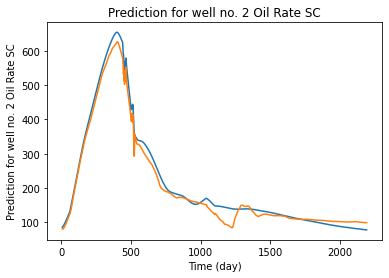

Model for well number 2 and Oil Rate SC is fitted with RMSE: 19.6693.


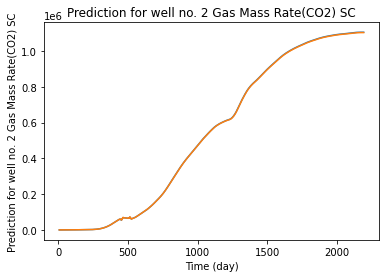

Model for well number 2 and Gas Mass Rate(CO2) SC is fitted with RMSE: 1377.7381.


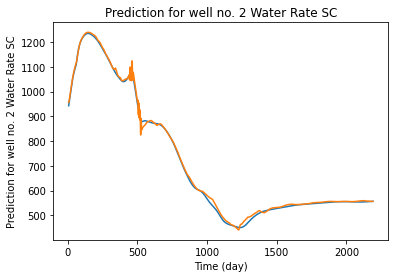

Model for well number 2 and Water Rate SC is fitted with RMSE: 8.7193.
Model for well number 2 is fitted with average error: 3.5118%.
Dataset for well no. 3 is prepared for keras.
Epoch 1/50
69/69 [==============================] - 1s 18ms/step - loss: 33756024.0000 - mean_absolute_error: 1637.6066 - val_loss: 3790037.7500 - val_mean_absolute_error: 69.6083
Epoch 2/50
69/69 [==============================] - 1s 12ms/step - loss: 3253749.0000 - mean_absolute_error: 169.4071 - val_loss: 2643125.7500 - val_mean_absolute_error: 190.5735
Epoch 3/50
69/69 [==============================] - 1s 11ms/step - loss: 2317910.7500 - mean_absolute_error: 51.6316 - val_loss: 2092179.1250 - val_mean_absolute_error: 41.2602
Epoch 4/50
69/69 [==============================] - 1s 11ms/step - loss: 1950392.8750 - mean_absolute_error: 26.2605 - val_loss: 1819140.0000 - val_mean_absolute_error: 38.7332
Epoch 5/50
69/69 [==============================] - 1s 11ms/step - loss: 1704749.7500 - mean_absolute_error

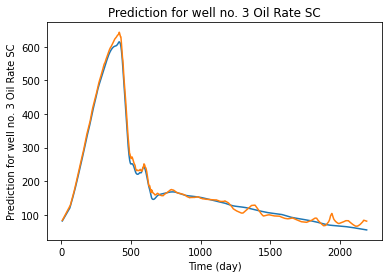

Model for well number 3 and Oil Rate SC is fitted with RMSE: 10.6881.


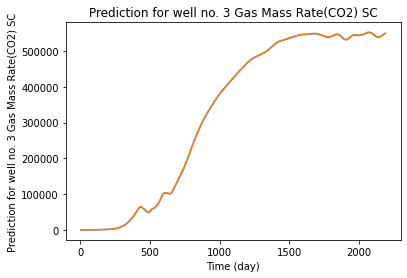

Model for well number 3 and Gas Mass Rate(CO2) SC is fitted with RMSE: 417.8463.


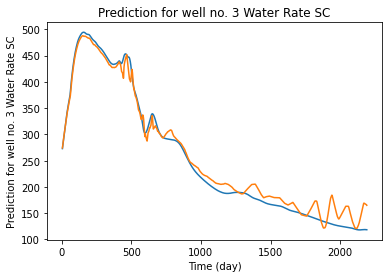

Model for well number 3 and Water Rate SC is fitted with RMSE: 16.2362.
Model for well number 3 is fitted with average error: 4.7621%.
Dataset for well no. 4 is prepared for keras.
Epoch 1/50
69/69 [==============================] - 1s 19ms/step - loss: 37486668.0000 - mean_absolute_error: 1989.3055 - val_loss: 4978421.0000 - val_mean_absolute_error: 219.1340
Epoch 2/50
69/69 [==============================] - 1s 13ms/step - loss: 4285116.5000 - mean_absolute_error: 234.6219 - val_loss: 3538937.0000 - val_mean_absolute_error: 112.1610
Epoch 3/50
69/69 [==============================] - 1s 13ms/step - loss: 3228551.5000 - mean_absolute_error: 157.3063 - val_loss: 2924595.7500 - val_mean_absolute_error: 77.0771
Epoch 4/50
69/69 [==============================] - 1s 12ms/step - loss: 2756649.2500 - mean_absolute_error: 98.6982 - val_loss: 2609889.0000 - val_mean_absolute_error: 135.6867
Epoch 5/50
69/69 [==============================] - 1s 12ms/step - loss: 2467522.0000 - mean_absolute_e

KeyboardInterrupt: ignored

In [ ]:


# Fit the model validation:
a_ls_tr, l_ls, l_pred_ls, model_ls_tr, avg_score, rmse_ls_all, std_ls_all, time_ax = \
    ts_model.pipeline_model_split(var_split=var_split_tr, const_split=const_split_tr,
                                  time_split=time_split_tr, grad_split=grad_split_tr,
                                  coor_split=coor_split_tr, target_split=target_split_tr, plot_=True)

# Store the results:
dir_fit = dir_ts + fit_f
for well_ in range(n_well):
    for var_ in range(n_var):
        f_dir = dir_fit + "Well_" + str(well_ + 1) + "_" + str(var_col[var_])
        df_l = pd.DataFrame(l_ls[well_][var_])
        df_l.to_csv(f_dir + "_train.csv")
        df_e = pd.DataFrame([avg_score[well_][var_]])
        df_e.to_csv(f_dir + "_error.csv")
        df_rmse = pd.DataFrame([rmse_ls_all[well_][var_]])
        df_rmse.to_csv(f_dir + "_rmse.csv")
        df_std = pd.DataFrame([std_ls_all[well_][var_]])
        df_std.to_csv(f_dir + "_std.csv")
        df_time = pd.DataFrame(time_ax)
        df_time.to_csv(f_dir + "_time.csv")
    f_dir = dir_fit + "Well_" + str(well_ + 1) + "_Prediction"
    df_l_pred = pd.DataFrame(l_pred_ls[well_])
    df_l_pred.to_csv(f_dir + "_pred.csv")
#
# Predict the testing data:
l_ls, l_pred_ls, avg_score, rmse_ls_all, std_ls_all, time_ax = \
    ts_model.get_prediction(model_=model_ls_tr, var_split=var_split_ts,
                            const_split=const_split_ts, time_split=time_split_ts,
                            grad_split=grad_split_ts, coor_split=coor_split_ts,
                            target_split=target_split_ts, plot_=False)
#
# Store the results:
dir_fit = dir_ts + test_over_data
for well_ in range(n_well):
    for var_ in range(n_var):
        f_dir = dir_fit + "Well_" + str(well_ + 1) + "_" + str(var_col[var_])
        df_l = pd.DataFrame(l_ls[well_][var_])
        df_l.to_csv(f_dir + "_test.csv")
        df_l_pred = pd.DataFrame(l_pred_ls[well_][var_])
        df_l_pred.to_csv(f_dir + "_pred.csv")
        df_e = pd.DataFrame([avg_score[well_][var_]])
        df_e.to_csv(f_dir + "_error.csv")
        df_rmse = pd.DataFrame([rmse_ls_all[well_][var_]])
        df_rmse.to_csv(f_dir + "_rmse.csv")
        df_std = pd.DataFrame([std_ls_all[well_][var_]])
        df_std.to_csv(f_dir + "_std.csv")
        df_time = pd.DataFrame(time_ax)
        df_time.to_csv(f_dir + "_time.csv")
#
'''
# Predict with the walk-forward:
n_iter = np.shape(time_split_ts)[1] - (n_old_obs + 3)
avg_score_t, l_ls, l_pred_ls, avg_score, rmse_ls_all, std_ls_all, time_ax = \
    ts_model.get_forecast_split(model_=model_ls_tr, n_iter=n_iter, weight_matrix=weight_matrix,
                                var_split=var_split_ts, const_split=const_split_ts,
                                time_split=time_split_ts, grad_split=grad_split_ts,
                                coor_split=coor_split_ts, target_split=target_split_ts,
                                plot_=False, new_well=False, plot_w=None)
#
# Store the results:
dir_fit = dir_ts + test_walk_forward
for well_ in range(n_well):
    for var_ in range(n_var):
        f_dir = dir_fit + "Well_" + str(well_ + 1) + "_" + str(var_col[var_])
        df_l = pd.DataFrame(l_ls[well_][var_])
        df_l.to_csv(f_dir + "_test.csv")
        df_l_pred = pd.DataFrame(l_pred_ls[well_][var_])
        df_l_pred.to_csv(f_dir + "_pred.csv")
        df_e = pd.DataFrame([avg_score[well_][var_]])
        df_e.to_csv(f_dir + "_error.csv")
        df_rmse = pd.DataFrame([rmse_ls_all[well_][var_]])
        df_rmse.to_csv(f_dir + "_rmse.csv")
        df_std = pd.DataFrame([std_ls_all[well_][var_]])
        df_std.to_csv(f_dir + "_std.csv")
        df_time = pd.DataFrame(time_ax)
        df_time.to_csv(f_dir + "_time.csv")
#
'''
# Import the information for the new well:
dir_n_well = ts_model.dir_n_well
pred_df_r_ls, pred_df_ls, norm_ = ts_model.get_df_list(dir_=dir_n_well, norm_=norm_,
                                                       init_=False, ext_1="PRED-", roll=False, pro_="03")
# Generate the new well (5 years => 1827 days) from the dataset:
l_pred_, time_ax = ts_model.pipeline_new_well_over_data(df_init_ls=pro_df_ls, df_new_ls=pred_df_ls,
                                                        model_ls_tr=model_ls_tr, n_iter=1825,
                                                        new_factor=2, plot_=False)
#
# Store the results:
dir_fit = dir_ts + new_well_over_data
for var_ in range(n_var):
    f_dir = dir_fit + "PRED_" + "_" + str(var_col[var_])
    df_l_pred = pd.DataFrame(l_pred_[var_])
    df_l_pred.to_csv(f_dir + "_pred.csv")
    df_time = pd.DataFrame(time_ax)
    df_time.to_csv(f_dir + "_time.csv")
#
'''
# Generate the new well (5 years => 1827 days):
l_pred_, l_pred_ls, time_ax = ts_model.pipeline_new_well(df_init_ls=pro_df_ls, df_new_ls=pred_df_ls,
                                                         model_ls_tr=model_ls_tr, n_iter=1825,
                                                         new_factor=3, plot_=False)
#
# Store the results:
dir_fit = dir_ts + new_well_forward
for var_ in range(n_var):
    f_dir = dir_fit + "PRED_" + "_" + str(var_col[var_])
    df_l_pred = pd.DataFrame(l_pred_[var_])
    df_l_pred.to_csv(f_dir + "_pred.csv")
    df_time = pd.DataFrame(time_ax)
    df_time.to_csv(f_dir + "_time.csv")

#'''